In [1]:
# Please uncomment the below lines if XGBoost / SKlearn are not yet installed

!pip install xgboost
!pip install sklearn

### Import all necessary libraries

In [2]:
import pandas as pd
import numpy as np
from hdfs import InsecureClient
from sapdi import tracking

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from xgboost import plot_importance
%matplotlib inline
import matplotlib.pyplot as plt

import time
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
np.random.seed(20)

from warnings import filterwarnings
filterwarnings('ignore')

### Load the dataset that we uploaded using ML Data Manager

In [3]:
client = InsecureClient('http://datalake:50070')
with client.read('/shared/ml/data/Power_Analysis/Household Power train data/household_power_consumption_hours.csv',
                 encoding = 'utf-8') as reader:
    
    df = pd.read_csv(reader,
                     index_col=[0],
                     date_parser= pd.to_datetime,
                     infer_datetime_format=True,
                     low_memory=False
                    )

In [4]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


### Prepare the data into a Univariate Time-Series Problem

In [5]:
df_timeseries = pd.DataFrame(df.Global_active_power)
df_timeseries.head()

,Global_active_power
datetime,
2006-12-16 17:00:00,152.024
2006-12-16 18:00:00,217.932
2006-12-16 19:00:00,204.014
2006-12-16 20:00:00,196.114
2006-12-16 21:00:00,183.388


### Time-Series Feature Engineering

#### Create Lag Variable 

We will create 10 lag variables as new features in our dataset.
Our ML model will look into these features to predict the next value


In [6]:
lag = 40
for i in range(lag):
    df_timeseries['lag_{}'.format(i)] = df_timeseries.Global_active_power.shift(i)
    
df_timeseries.head()

,Global_active_power,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39
datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:00:00,152.024,152.024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 18:00:00,217.932,217.932,152.024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 19:00:00,204.014,204.014,217.932,152.024,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 20:00:00,196.114,196.114,204.014,217.932,152.024,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 21:00:00,183.388,183.388,196.114,204.014,217.932,152.024,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The Shift operation will create a lot of missing values (NaN) in the data

In [7]:
# Check for NaN value in each column
df_timeseries.isna().sum()

Global_active_power     0
lag_0                   0
lag_1                   1
lag_2                   2
lag_3                   3
lag_4                   4
lag_5                   5
lag_6                   6
lag_7                   7
lag_8                   8
lag_9                   9
lag_10                 10
lag_11                 11
lag_12                 12
lag_13                 13
lag_14                 14
lag_15                 15
lag_16                 16
lag_17                 17
lag_18                 18
lag_19                 19
lag_20                 20
lag_21                 21
lag_22                 22
lag_23                 23
lag_24                 24
lag_25                 25
lag_26                 26
lag_27                 27
lag_28                 28
lag_29                 29
lag_30                 30
lag_31                 31
lag_32                 32
lag_33                 33
lag_34                 34
lag_35                 35
lag_36                 36
lag_37      

<br>
We will remove the rows with missing values and break the dataset into features and labels

In [8]:
y = df_timeseries.dropna().Global_active_power
X = df_timeseries.dropna().drop(['Global_active_power'],axis =1)

### Split the dataset into train and test

We take the last 100 observations as Testing data and the remaining as the Training Data

In [9]:
X_train = X.iloc[:-100]
y_train = y.iloc[:-100]

X_test = X.iloc[-100:]
y_test = y.iloc[-100:]

In [10]:
print('X_train Shape :{}'.format(X_train.shape))
print('y_train Shape :{}'.format(y_train.shape))

X_train Shape :(34450, 40)
y_train Shape :(34450,)


In [11]:
print('X_test Shape :{}'.format(X_test.shape))
print('y_test Shape :{}'.format(y_test.shape))

X_test Shape :(100, 40)
y_test Shape :(100,)


### Scaling the data

Standardization of a dataset is a common requirement for many machine learning estimators as they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Training

#### XGBoost

In [13]:
start = time.time()

# Initialize SAP DI Tracking 
run = tracking.start_run(run_collection_name='power_consumption_run')

eval_set = [(X_test_scaled, y_test)]

# create XGBoost Regressor model
xgb_model = xgb.XGBRegressor()

# Start training
xgb_model.fit(X_train_scaled,
          y_train,
          eval_metric="rmse",
          eval_set=eval_set,
          early_stopping_rounds=5,
          verbose=True)

# Tracking Parameters
tracking.log_parameters(parameters=xgb_model.get_xgb_params())

tracking.log_parameters(parameters = {'random_seed': 20})

print('\nXGBoost Model Training Completed in {} seconds'.format(time.time()-start))

[0]	validation_0-rmse:57.91327
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:40.53788
[2]	validation_0-rmse:28.40465
[3]	validation_0-rmse:19.85997
[4]	validation_0-rmse:13.91258
[5]	validation_0-rmse:9.76703
[6]	validation_0-rmse:6.83741
[7]	validation_0-rmse:4.80959
[8]	validation_0-rmse:3.40716
[9]	validation_0-rmse:2.44090
[10]	validation_0-rmse:1.77079
[11]	validation_0-rmse:1.31502
[12]	validation_0-rmse:1.02060
[13]	validation_0-rmse:0.82754
[14]	validation_0-rmse:0.72170
[15]	validation_0-rmse:0.64622
[16]	validation_0-rmse:0.60984
[17]	validation_0-rmse:0.59326
[18]	validation_0-rmse:0.58180
[19]	validation_0-rmse:0.57712
[20]	validation_0-rmse:0.57430
[21]	validation_0-rmse:0.56452
[22]	validation_0-rmse:0.56343
[23]	validation_0-rmse:0.56315
[24]	validation_0-rmse:0.56114
[25]	validation_0-rmse:0.55779
[26]	validation_0-rmse:0.55776
[27]	validation_0-rmse:0.55782
[28]	validation_0-rmse:0.55787
[29]	validation_0-rmse:0.55724
[30]	valida

In [14]:
# Log Metric 
tracking.log_metric('RMSE' , xgb_model.best_score )

In [15]:
print('Best RMSE for XGBoost model with Test Set: {}'.format(xgb_model.best_score))

Best RMSE for XGBoost model with Test Set: 0.535075


In [16]:
# Set tags
tracking.set_tags({
    "model" : "XGboostRegressor"
})

tracking.end_run()

In [17]:
df_actual_and_predicted = pd.DataFrame(index=X_test.index)
df_actual_and_predicted['actual'] = y_test
df_actual_and_predicted['XGboost_preds'] = xgb_model.predict(X_test_scaled)

##### Lets forecast for future periods

In [18]:
def generate_future_timestamps(num_prediction):
    last_date = df_timeseries.index[-1]
    prediction_dates = pd.date_range(last_date,freq='H', periods=num_prediction).tolist()
    return prediction_dates

forecast_dates = generate_future_timestamps(40)

In [19]:
X_scaled = scaler.transform(X)

last_row = X.iloc[-1]

In [20]:
# This function forecasts recursively by predicting one value and then combining it with 
# previous values to forecast next values

def generate_forecasts(model, n_periods_to_forecast, row_to_begin_forecast, scaler_object, scaled_data ):
    
    begin_scaled_row_for_pred = scaled_data[-1:]
    
    forecasts = list()
    for i in range(n_periods_to_forecast):
        forecast = model.predict(begin_scaled_row_for_pred)
        next_row = row_to_begin_forecast.shift(-1).fillna(forecast[0])
        begin_scaled_row_for_pred = np.array(scaler_object.transform([next_row]))
        row_to_begin_forecast = next_row
        forecasts.append(forecast[0])
            
    return forecasts

In [21]:
xg_future_forecasts = generate_forecasts(model=xgb_model,
                                  n_periods_to_forecast=40,
                                  row_to_begin_forecast=last_row,
                                  scaler_object=scaler,
                                  scaled_data=X_scaled
                                 )

In [22]:
df_future_forecasts = pd.DataFrame()
df_future_forecasts['datetime'] = forecast_dates[1:]
df_future_forecasts['xgboost_predictions'] = xg_future_forecasts[1:]

In [23]:
df_future_forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             39 non-null     datetime64[ns]
 1   xgboost_predictions  39 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 752.0 bytes


In [24]:
df_future_forecasts.set_index('datetime',inplace=True)

<Figure size 720x864 with 0 Axes>

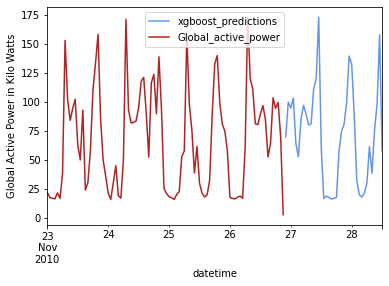

In [25]:
plt.figure(figsize=(10,12))
ax = df_future_forecasts.plot(color = 'cornflowerblue')
ax = df_timeseries['11/23/2010':].Global_active_power.plot(color = 'firebrick')
ax.set_ylabel('Global Active Power in Kilo Watts')
ax.legend()
plt.show()

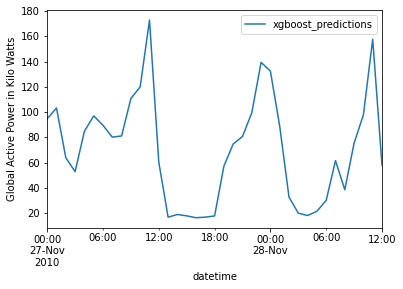

In [26]:
ax = df_future_forecasts['11/27/2010': '11/29/2010'].xgboost_predictions.plot()
ax.set_ylabel('Global Active Power in Kilo Watts')
ax.legend()
plt.show()

In [27]:
# Save trained model to disk
import pickle
filename = 'XGBoost_model_for_power_consumption.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

In [28]:
# Save training data to disk for inference usage
filename = 'inference_data_for_regression_models.pkl'
pickle.dump(X, open(filename, 'wb'))

### Random Forest

In [29]:
# Start training 
start = time.time()

run = tracking.start_run(run_collection_name='power_consumption_run')

randomforest_model = RandomForestRegressor()
randomforest_model.fit(X_train_scaled,y_train)
tracking.log_parameters(parameters=randomforest_model.get_params())

print('Random Forest Model Training Completed in {} seconds'.format(time.time()-start))

Random Forest Model Training Completed in 111.8310763835907 seconds


In [30]:
randomforest_predictions = randomforest_model.predict(X_test_scaled)

In [31]:
df_actual_and_predicted['randomforest_predictions'] = randomforest_predictions

In [32]:
randomforest_rmse = np.sqrt(mean_squared_error(df_actual_and_predicted.actual, df_actual_and_predicted.randomforest_predictions))

In [33]:
from sklearn.metrics import mean_squared_error
print('RMSE with RandomForest is {}'.format(randomforest_rmse))

RMSE with RandomForest is 0.4815740359487824


In [34]:
# Log Metric
tracking.log_metric('RMSE' ,randomforest_rmse )

In [35]:
tracking.set_tags({
    "model" : "RandomForestRegressor"
})

tracking.end_run()

In [36]:
randomforest_future_forecasts = generate_forecasts(model=randomforest_model,
                                                   n_periods_to_forecast=40,
                                                   row_to_begin_forecast=last_row,
                                                   scaler_object=scaler,
                                                   scaled_data=X_scaled
                                                  )

In [37]:
df_future_forecasts['randomforest_predictions'] = randomforest_future_forecasts[1:]

In [38]:
df_future_forecasts.head()

,xgboost_predictions,randomforest_predictions
datetime,,
2010-11-26 22:00:00,69.779823,69.82384
2010-11-26 23:00:00,99.792633,99.55580
2010-11-27 00:00:00,94.750786,94.41286
2010-11-27 01:00:00,103.236877,103.54388
2010-11-27 02:00:00,63.878429,64.08582


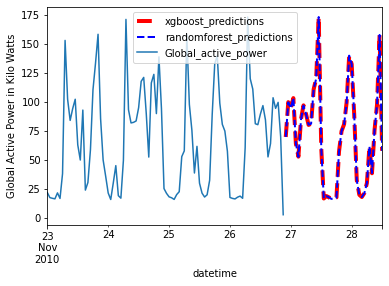

In [39]:
ax = df_future_forecasts.xgboost_predictions.plot( linewidth=4, linestyle='--',color = 'r')
ax = df_future_forecasts.randomforest_predictions.plot(linewidth=2, linestyle='dashed',color = 'b' )
ax = df_timeseries['11/23/2010':].Global_active_power.plot()
ax.set_ylabel('Global Active Power in Kilo Watts')
ax.legend()
plt.show()

#### We can see that predictions / forecasts from both the models are overlapping and also have similar RMSE values. 

In [40]:
filename = 'Random_Forest_model_for_power_consumption.pkl'
pickle.dump(randomforest_model, open(filename, 'wb'))

#### Plot Metrics from Tracking SDK

In [41]:
import sapdi
import json

In [42]:
sc = sapdi.get_current_scenario()

In [44]:
run_data =  tracking.get_runs( scenario = sc,notebook = sapdi.scenario.Notebook.get(notebook_id=r"20 Training Regression Models.ipynb"))

In [45]:
run_json = json.loads(str(run_data))

In [66]:
df = pd.DataFrame.from_dict(run_json[0]['metrics'])

In [67]:
df = pd.concat([df ,pd.DataFrame.from_dict(run_json[1]['metrics'])])
df = df.reset_index(drop=True)

In [69]:
s = pd.Series([run_json[0]['id'],run_json[1]['id']])
df.insert(1,'run_id',s)

In [70]:
models = pd.Series([run_json[0]['tags'].get('model'),run_json[1]['tags'].get('model')])
df.insert(1,'tags',models)

In [71]:
df

,name,tags,run_id,timestamp,value
0,RMSE,XGboostRegressor,ea9709f9-627a-45ce-bc43-bc14366b3856,2020-04-02T05:41:53.206537Z,0.535075
1,RMSE,RandomForestRegressor,35a4eb2d-16e6-42a6-b588-f5b0d8484862,2020-04-02T05:43:47.321461Z,0.481574


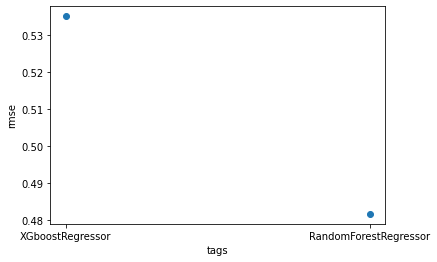

In [72]:
import matplotlib.pyplot as plt
plt.scatter(x = df.tags , y = df.value )
plt.xlabel('tags')
plt.ylabel('rmse')
plt.show()